# Estimating Photobleaching Rate Constants

In [157]:
import numpy as np
import skimage.io
import skimage.morphology
import skimage.measure
import skimage.segmentation
import skimage.filters
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as nd
import matplotlib.pyplot as plt
import mscl.plotting
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

##  The Problem

As is described in the notebook on [estimating the brightness of a single fluorophore](), we showed that we could use the difference in fluorescence between two daughter cells after a division to estimate a calibration factor linking intensity to protein copy number. Experimentally, this requires immobilization of some bacterial cells on a hard agar substrate followed by time lapse imaging over several hours to catch at least two separate division events. In order to properly calculate the fluorescence intensity of a single cell, we have to correct for the photobleaching $-$ the irreversible destruction of a fluorophore through excitation.

To this end, for each experiment we take photobleaching measurements of cells constitutively expressing sfGFP as well as cells with no fluorescent protein at all. We used these photobleaching traces to determine the bleaching rate constant(s) of the fluorophores and correct the measurements for the dilution experiment. 

## Measuring photobleaching

To begin, we will load the example photobleaching images and segment the bacterial cells. These images were taken at 100$\times$ magnification with a fluorescence exposure of 100ms. A phase contrast image was taken at the beginning of the time series followed by successive 100ms exposures with the excitation wavelength.  

In [9]:
# Load the constitutive expression images. 
images = skimage.io.imread('../../data/test_data/delta_bleaching_1/delta_bleaching_1_MMStack_Pos0.ome.tif')

# As these are OME.tif files, we will need to split them by channel and time. 
phase_im = images[0, 0, :, :] # This is a single image
fluo_ims = images[:, 1, :, :] # This is an array of the bleaching images

With the images loaded and split into individual files, we can show some of the images together for our own sanity.  

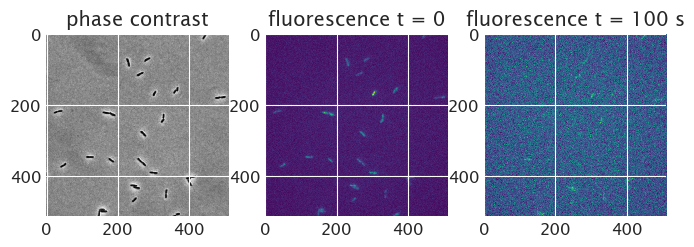

In [18]:
# Set the figure canvas
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
ax[0].set_title('phase contrast')
ax[1].set_title('fluorescence t = 0')
ax[2].set_title('fluorescence t = 100 s')

# Plot the images.
_ = ax[0].imshow(phase_im, cmap='Greys_r')
_ = ax[1].imshow(fluo_ims[0], cmap='viridis')
_ = ax[2].imshow(fluo_ims[-1], cmap='viridis')

It does appear that this is the appropriate phase contrast and fluorescent pair, and it makes sense that the fluorescence image at $t = 0$ is brighter than at $t = 100$ s.  We can now segment the phase image to measure individual cells. As there may be some slight drift in of the field of view over the 100 s of acquisition, we wil dilate this segmentation mask such that the measured area is larger than the cell itself. Below, we define two functions that will perform this segmentation.  

In [27]:
def normalize_image(im, sub_bg=True):
    """
    Rescales the values of an image between 0 and 1. Can also perform a
    background subtraction.

    Parameters
    ----------
    im : 2d-array
        Image to be normalized.
    sub_bg: bool, default True.
        If True, a gaussian background subtraction is performed with
        a small sd.
    Returns
    -------
    im_norm : 2d-array
        Normalized image. If sub_bg is True, these values are on
        the domain [-1, 1]. If sub_bg is False, values are on [0, 1]
    """
    im_norm = (im - im.min()) / (im.max() - im.min())
    if sub_bg is True:
        im_blur = skimage.filters.gaussian(im_norm, sigma=5)
        im_norm = im_norm - im_blur
    return im_norm


def threshold_phase(im, min_int=0.15):
    """
    erforms an intensity based segmentation of a phase contrast image.
    This function uses Otsu's method to determine the threshold value.

    Parameters
    ----------
    im: 2d-array
        Image to be segmented. Desired objects in this image are assumed
        to be dark.
    min_int : float
        The maximum mean pixel intensity of a segmented object. This
        value must be between 0 and 1. Default is 0.15

    Returns
    -------
    mask: 2d-array, int
        Segmented image with labeled regions.
    """

    # Preprocess the phase image.
    im_sub = normalize_image(im)
    im_float = normalize_image(im, sub_bg=False)

    # Use Otsu's method.
    thresh = skimage.filters.threshold_otsu(im_sub)

    # Clean initial segmentation.
    seg = skimage.segmentation.clear_border(im_sub < thresh)
    seg = skimage.morphology.remove_small_objects(seg)
    mask = skimage.measure.label(seg)

    # Oversegment to correct for slight drift.
    selem = skimage.morphology.disk(2)
    mask = skimage.morphology.dilation(mask, selem)
    lab = skimage.measure.label(mask)

    # Impose minimum intensity filter.
    props = skimage.measure.regionprops(lab, im_float)
    final_im = np.zeros_like(mask)
    for prop in props:
        mean_int = prop.min_intensity
        if mean_int <= min_int:
            final_im += (lab == prop.label)
    dil = skimage.morphology.binary_dilation(final_im)
    mask = skimage.measure.label(dil)
    return mask

Now we can test out this function on our phase contrast image and overlay the segmentation mask.  

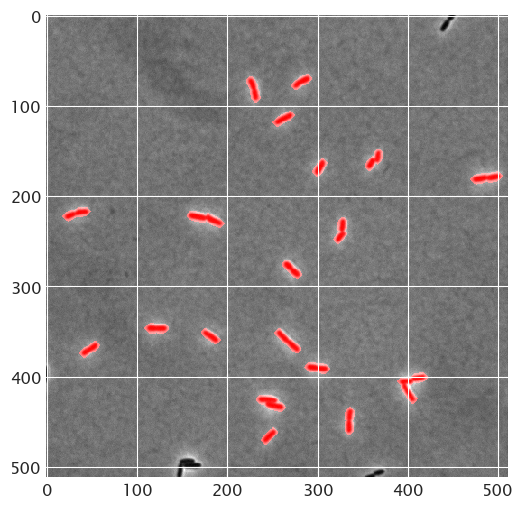

In [28]:
# Segment the phase contrast image. 
seg = threshold_phase(phase_im)

# Normalize the original phase contrast image and make a copy.
im_norm = normalize_image(phase_im, sub_bg=False)
im_copy = np.copy(im_norm)

# Create the overlay.
im_copy[seg > 0] = 1.0
overlay = np.dstack((im_copy, im_norm, im_norm))

# Create the figure canvas and display the image.
fig, ax = plt.subplots(1,1)
_ = ax.imshow(overlay)

With a solid segmentation mask in place, we can now extract the fluorescence information. We will loop through each image, subtract the median background fluorescence, and will measure the cell-by-cell integrated intensity.

In [39]:
# Set up the storage DataFrame
delta_df = pd.DataFrame([], columns=['cell_id', 'time_s', 'total_intensity'])

# Define the exposure time 
exposure = 0.1 # in units of seconds.

# Loop through each fluorescence image.
time = 0
for i, im in enumerate(fluo_ims):
    # Generate the inverse segmentation mask.
    inv_mask = seg < 1 
    
    # Compute the median fluorescence of the background image.
    median_bg = np.median(im[inv_mask])
    
    # Extract the region properties for each cell.
    props = skimage.measure.regionprops(seg, im)
    
    # Loop through each cell and add the intensity to the dataframe.
    for j, p in enumerate(props):
        cell_id = p.label
        total_int = (p.mean_intensity * p.area) - median_bg
        delta_df = delta_df.append(dict(cell_id=cell_id, total_intensity=total_int,
                                       time_s=time), ignore_index=True)

    # Update the time.
    time += exposure

With the images processed, we can look at a single cell (say, cell number 3) and plot it's intensity as a function of time.

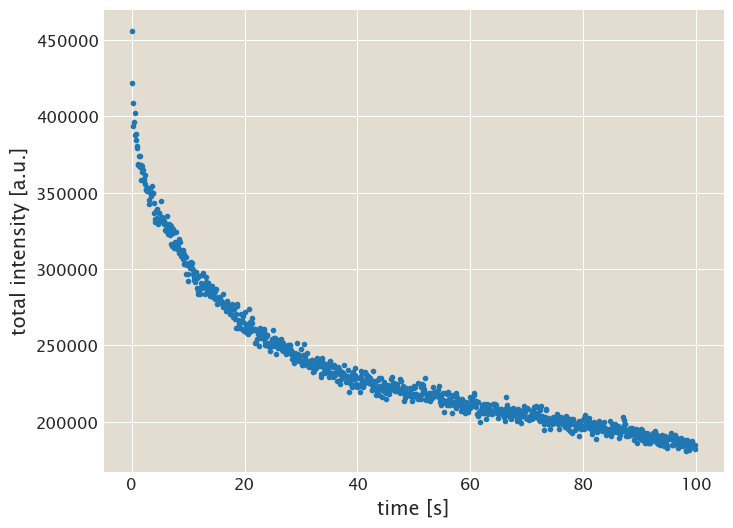

In [40]:
# Isolate a cell
cell = delta_df[delta_df['cell_id']==3]

# Set up the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('total intensity [a.u.]')

# Plot the traces.
_ = ax.plot(cell['time_s'], cell['total_intensity'], '.')

This matches our expectation $-$ the total intensity (qualitatively) decreases exponentially as a function of exposure time. We can plot the traces from all of the cells together to get an idea of the distribution. We will also plot the fractional intensity so each trace is directly comparable.

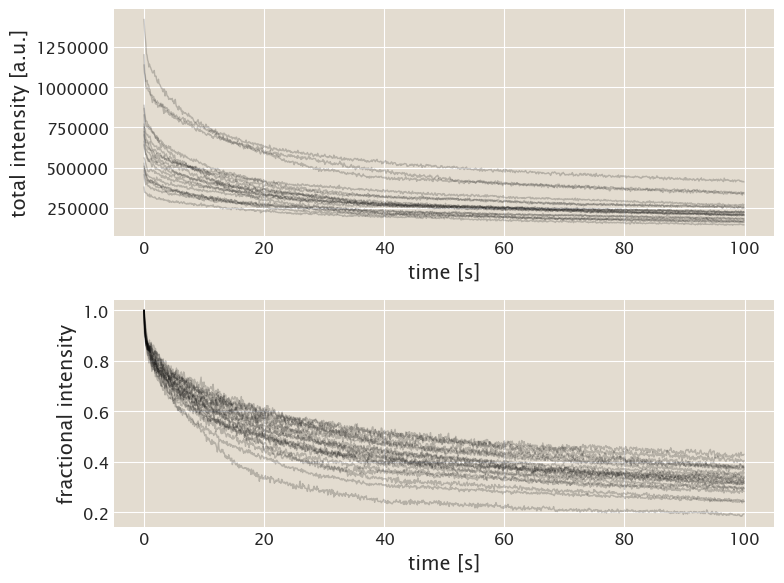

In [55]:
# Plot the raw traces and the fractional intensity.
grouped = delta_df.groupby('cell_id')

# Set up the figure canvas
fig, ax = plt.subplots(2, 1)
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')
ax[0].set_ylabel('total intensity [a.u.]')
ax[1].set_ylabel('fractional intensity')

# Loop through each grouped cell object and plot
for g, d in grouped:
    _ = ax[0].plot(d['time_s'], d['total_intensity'], 'k-', alpha=0.2, lw=1)
    _ = ax[1].plot(d['time_s'], d['total_intensity']/d['total_intensity'].iloc[0], 'k-', alpha=0.2,
                  lw=1)
plt.tight_layout()

There appears to be some heterogeneity in the expression, which is what we would naively expect.  It's comforting that the fractional decay is similar between all of the cells. Lumped into these traces, however, is the bleaching of the autofluorescence. We can now load the autofluorescence images and repeat the above processing.

In [56]:
# Load the autofluorescence images.
auto_ims = skimage.io.imread('../../data/test_data/autofluorescence_bleaching_2/autofluorescence_bleaching_2_MMStack_Pos0.ome.tif')

# Split them into phase and fluorescence.
phase_im = auto_ims[0, 0, :, :]
fluo_ims = auto_ims[:, 1, :, :]

# Segment the phase contrast image.
seg = threshold_phase(phase_im)

# Extract the fluorescence information
auto_df = pd.DataFrame([], columns=['cell_id', 'time_s', 'total_intensity'])

# Loop through each fluorescence image.
time = 0
for i, im in enumerate(fluo_ims):
    # Generate the inverse segmentation mask.
    inv_mask = seg < 1 
    
    # Compute the median fluorescence of the background image.
    median_bg = np.median(im[inv_mask])
    
    # Extract the region properties for each cell.
    props = skimage.measure.regionprops(seg, im)
    
    # Loop through each cell and add the intensity to the dataframe.
    for j, p in enumerate(props):
        cell_id = p.label
        total_int = (p.mean_intensity * p.area) - median_bg
        auto_df = auto_df.append(dict(cell_id=cell_id, total_intensity=total_int,
                                       time_s=time), ignore_index=True)

    # Update the time.
    time += exposure

Now we'll plot the raw and rescaled traces for each autofluorescent cell. 


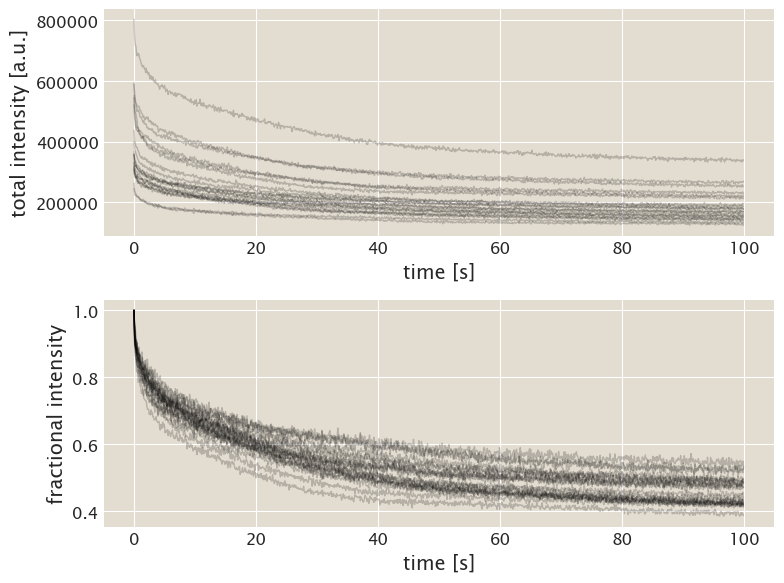

In [57]:
# Plot the raw traces and the fractional intensity.
grouped = auto_df.groupby('cell_id')

# Set up the figure canvas
fig, ax = plt.subplots(2, 1)
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')
ax[0].set_ylabel('total intensity [a.u.]')
ax[1].set_ylabel('fractional intensity')

# Loop through each grouped cell object and plot
for g, d in grouped:
    _ = ax[0].plot(d['time_s'], d['total_intensity'], 'k-', alpha=0.2, lw=1)
    _ = ax[1].plot(d['time_s'], d['total_intensity']/d['total_intensity'].iloc[0], 'k-', alpha=0.2,
                  lw=1)
plt.tight_layout()

This also agrees with our intuitive expectation. To correct for this autofluorescence photobleaching, we can take the average autofluorescence value at each time point and subtract it from our constitutively expressing cells. 

In [84]:
# Compute the mean autofluorescence value at each time point
mean_auto = auto_df.groupby('time_s')['total_intensity'].mean().values

# Set up the storage list for the subtracted dataframes
sub_df = []
grouped = delta_df.groupby('time_s')
t = 0
for g, d in grouped: 
    d = d.copy()
    d.loc[:, 'subtracted'] = d.loc[:, 'total_intensity'] - mean_auto[t]
    sub_df.append(d)
    t += 1

# Make the subtracted dataframe list one dataframe.
sub_df = pd.concat(sub_df)

With the subtracted data, let's plot the fractional intensity along with the average. 

In [92]:
# Group by the cell ID
grouped = sub_df.groupby('cell_id')
rescaled_df = []
for g, d in grouped:
    # Fine the intensity at time 0.
    I0 = d.loc[d['time_s']==0]['total_intensity'].values
    d.loc[:, 'rescaled_intensity'] = d.loc[:, 'total_intensity'] / I0
    rescaled_df.append(d)
    
# Group them into a single dataframe. 
rescaled_df = pd.concat(rescaled_df)

# Compute the average and groupby the time.
time_grouped = rescaled_df.groupby('time_s')
average_rescaled = []
for g, d in time_grouped:
    avg = d.loc[:, 'rescaled_intensity'].mean()
    average_rescaled.append(avg)

/Users/gchure/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


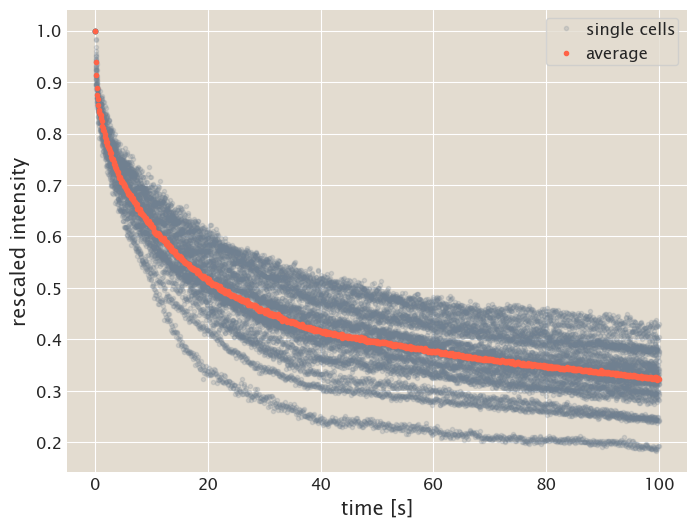

In [99]:
# Set the figure canvas
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('rescaled intensity')

# Plot the rescaled data.
_ = ax.plot(rescaled_df['time_s'], rescaled_df['rescaled_intensity'], '.', 
            color='slategray', alpha=0.2, label='single cells')

# Plot the averaged values.
_ = ax. plot(rescaled_df['time_s'].unique(), average_rescaled, '.', color='tomato', 
            label='average')

_ = plt.legend()

Now that we've processed the images and extracted the intensity images, we gat perform the parameter estimation.

## The Model 

There are fa few different ways by which we can treat these photobleaching traces. We can perofrm the parameter estimation for each trace individually and then approximating the estimated parameters as gaussian and taking a mean and standard deviation. A more complicated approach (although it is more attractive from a statistical timepoint) is to construct a heirarchical model, assuming that the time constant(s) are drawn from some distribution and then estimating this distribution. Both of these approaches are computationally expensive, however, which a heirarchical model having at least $3\, \times\, n_\text{cells} + 6$ parameters and requiring sampling through Markov Chain Monte Carlo. 

Another approach is to perform the parameter estimation on the *average* of the traces, as we've plotted above. While this may not be the most "proper" treatment of this problem, it is more computationally tractable and is approximate. There are many sources of variation in the decay rate constants due to nonuniformity of the field or variations in the cells themselves. Because of the numerous sources of variation, we will estimate the parameter values from the averaged trace alone. 

###  Model I: Single Exponential Decay

It's reasonable to assume that the irreversible photobleaching of pool of fluorescent proteins should follow a single exponential decay of the form,

$$
I(t) = \beta  + I_0\exp\left[{-t / \tau}\right],
\tag{1}
$$

where $I(t)$ is the intensity at time $t$, $\beta$ is the fluorescence floor (background), $I_0$ is the initial intensity from the fluorophores, and $\tau$ is the decay constant in units of time. We can use the rescaled average trace calculated above as our data for $I(t)$, meaning we must estimate $I_0,\, \beta$ and $\tau$. As is usually the case, we begin by writing down Bayes' theorem,

$$
P(\beta, I_0, \tau\, \vert\, \mathbf{D}, t) \propto P(\mathbf{D}\,\vert\, \beta, I_0, \tau) P(\beta)P(I_0)P(\tau),
\tag{2}
$$

where $\mathbf{D}$ is our set of data.  In Eq. 2, we have three priors for the thtree parameters, assuming they are independent of one another. With Eq. 1 as our physical model, we can assume that the spread of data around this expectation is Gaussian. Our likelihood can be written as 

$$
P(\mathbf{D}, t\, \vert \, \beta, I_0, \tau) = {1 \over \sqrt{2\pi\sigma^2}}\exp\left[{1 \over \sigma^{2n}}\sum\limits_{i \in \mathbf{D}}^n (I(t)_i - I(t)_i^*)^2\right],
\tag{3}
$$

where $I(t)_i^*$ is the predicted intensity at time $t$ and $n$ is the number of points in the data set. This introduces another parameter $\sigma$ which describes the variance in our measurement, and needs another prior. For the priors, we can be maximally uniformative and assume uniform distributions for $I_0$ and $\beta$, and Jeffrey's priors for $\sigma$ and $\tau$. Our posterior probability distribution can then be written as

$$
P(\beta, I_0, \tau\, \sigma, \vert\, t, \mathbf{D}) \propto {1 \over \tau}{1 \over \sigma}{1 \over \sqrt{2\pi\sigma^2}}\exp\left[{1 \over \sigma^{2n}}\sum\limits_{i \in \mathbf{D}}^n (I(t)_i - I(t)_i^*)^2\right].
\tag{4}
$$

As was performed in the [estimating the calibration factor notebook](), we can marginalize over $\sigma$,

$$
P(\beta, I_0, \tau\, \vert t, \mathbf{D}) = \int\limits_0^\infty d\sigma P(\beta, I_0, \tau, \sigma\, \vert\, t, \mathbf{D})P(\sigma)P(\beta)P(\tau)P(I_0)
\tag{5}
$$

to arrive at the Students t distribution, 

$$
P(\beta, I_0, \tau\, \vert\, t, \mathbf{D}) = {1 \over \tau} \left(\sum\limits_{i \in \mathbf{D}}^n (I(t)_i - I(t)_i^*)^2\right)^{-n  /2}.
\tag{6}
$$

Eq. 6 is the analytical solutiong for the single exponential decay model. We can find the most likely estimates of these parameters through optimization by minimization. Below, we define a function for the log posterior of a single exponential decay.

In [335]:
def log_posterior_exp(params, time, data, neg=True): 
    """
    Computes the log posterior for a single exponential decay.
    
    Parameters
    ----------
    params : list or tuple
        The parameter values for the background, the initial fluorophore intensity, and
        the time constant.
    time: list or 1d-array
        The time points overwhich the bleaching occurs.
    data : list or 1d-array
        The bleaching data
    neg : bool
        If True, the negative log posterior is returned. Default is True.
        
    Returns
    -------
    log_post : float
        The value of the log posterior given the parameter inputs.
    """ 
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1
    
    # Ensure nothing is below zero
    if (params < 0).any():
          return prefactor * -np.inf 
        
    beta, I_0, tau = params
    n = len(data)
    mu = beta + I_0 * np.exp(-time / tau)
    log_post = -np.log(tau) + -(n / 2) * np.log(np.sum((mu - data)**2)) 
    return prefactor * log_post
    

Now we can perform the minimization using Powell's method and find the most likely parameter values. 

In [339]:
# Define the time
time_vals = rescaled_df['time_s'].unique()

# Peform the minimization
guess = [0, 1, 1]
popt = scipy.optimize.minimize(log_posterior_exp, guess, args=(time_vals, average_rescaled), method='Powell')

# Extract the parameters.
beta, I_0, tau = popt.x
print("""
The most likely parameter values are:
            β : {0:.2f}
            I_0 : {1: .2f}
            τ : {2: .2f} s
""".format(beta, I_0, tau))


The most likely parameter values are:
            β : 0.34
            I_0 :  0.48
            τ :  20.44 s



We can examine the pairwise probability distributions for these parameters by evaluating the log posterior over a set of meshed parameter values and plotting the contours. Here, we look at the pairwise distributions for $\tau$ and the other parameters.

In [331]:
# Set up a range of beta, I_0, and tau
beta_range = np.linspace(0, 1, 100)
I_0_range = np.linspace(0, 1, 100)
tau_range = np.linspace(1E-3, 300, 100)

# Set up the meshes. 
b_x, b_y = np.meshgrid(tau_range, beta_range)
I_x, I_y = np.meshgrid(tau_range, I_0_range)

# Evaluate the posteriors.
beta_tau_post = np.zeros((len(beta_range), len(tau_range)))
for i, b in enumerate(beta_range):
    for j, t in enumerate(tau_range):
        beta_tau_post[i, j] = log_posterior_exp((b, I_0, t), time_vals, average_rescaled,
                                           neg=False)
        
I_0_tau_post = np.zeros((len(I_0_range), len(tau_range)))
for i, a in enumerate(I_0_range):
    for j, t in enumerate(tau_range):
        I_0_tau_post[i, j] = log_posterior_exp((beta, a, t), time_vals, average_rescaled,
                                           neg=False)

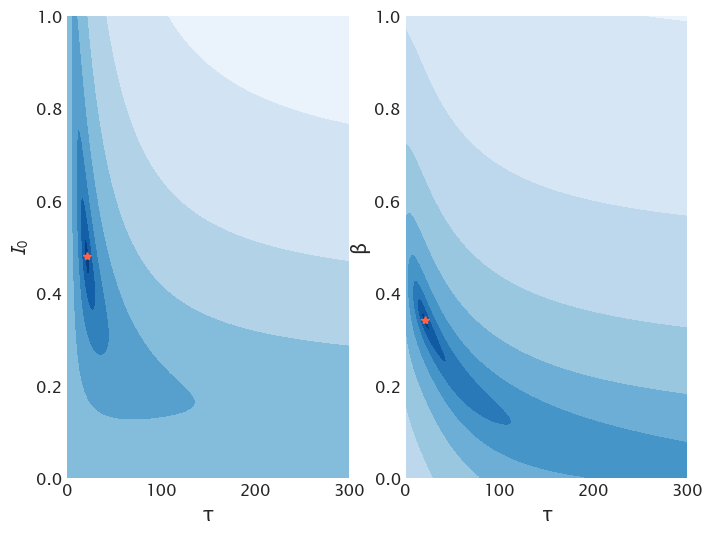

In [333]:
# Adjust the scaling so the posterior can be displayed
beta_tau_post = beta_tau_post / np.sum(beta_tau_post)
I_0_tau_post = I_0_tau_post / np.sum(I_0_tau_post)

# Set up the figure canvas
fig, ax = plt.subplots(1, 2)
ax[1].set_ylabel('β')
ax[0].set_xlabel('τ')
ax[0].set_ylabel('$I_0$')
ax[1].set_xlabel('τ')

# Plot the contours
_ = ax[0].contourf(I_x, I_y, np.exp(I_0_tau_post), cmap='Blues_r')
_ = ax[1].contourf(b_x, b_y, np.exp(beta_tau_post), cmap='Blues_r')

# Plot the MAP
_ = ax[0].plot(tau, I_0, '*', color='tomato')
_ = ax[1].plot(tau, beta, '*', color='tomato')

While these posteriors have one maximum, the posteriors are a little gross. That means that there is a lot of degeneracy in the parameter space. We can check if these parameter values make sense by plotting the fit over our data. 

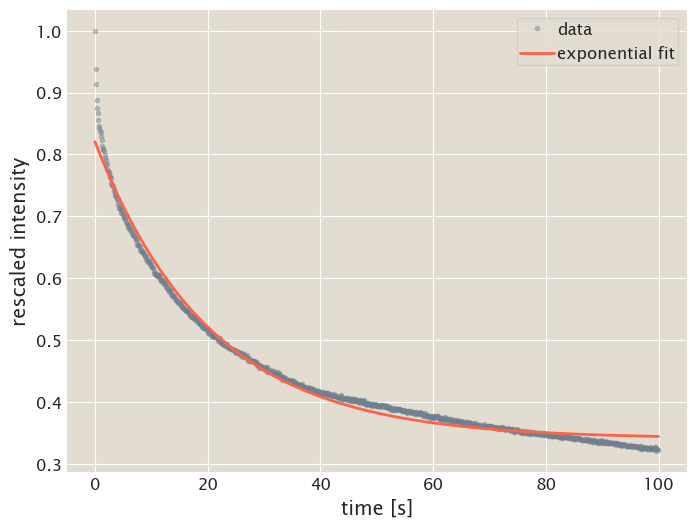

In [334]:
# Compute the fit with the optimal parameters.
time_range = np.linspace(0, 100, 300)
exp_fit = beta + I_0 * np.exp(-time_range / tau)

# Set up the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('rescaled intensity')

# Plot the data and the fits.
_ = ax.plot(time_vals, average_rescaled, '.', color='slategray', alpha=0.4, label='data')
_ = ax.plot(time_range, exp_fit, '-', color='tomato', label='exponential fit')
_ = ax.legend()

By eye, this appears to be a inaccurate fit of the data. This suggest that a single exponential fit does not capture the actual behavior of photobleaching. As we want to use this information to correct for photobleaching, it's more important to accurately predict the decay, especially in the first few hundred milliseconds. 

### Model II: Biexponential decay 

Even though these cells are expressing a single allele of a fluorescent protein, it is possible that there are multiple species of ths protein around in the cell with different bleaching constants. As there are typically multiple chemical mechanisms for photobleaching to occur, it is reasonable to fit these data by using a more complicated model. In the case of two species of fluorophore (one brighter than the other), we can write a model for a biexponential decay,

$$
I(t) = \beta + I_0^{(1)}\exp\left[{-t \over \tau_1}\right] + I_0^{(2)}\exp\left[{-t \over \tau_2}\right]
\tag{7}
$$

where $I_0^{(1)}$ and $I_0^{(2)}$ are the initial intensities of the two species of fluorophores. Note that each species of fluorophore also has its own decay constant $\tau$ that needs to be estimated. 

Luckily, our posterior shown in Eq. 6 is the same for this model, but we have an additional Jeffrey's prior for $\tau_2$. The only thing that changes is how we calculate the prediction with this new model. Below, we have defined another function for the log posterior of this biexponential treatment.

In [368]:
def log_posterior_biexp(params, time, data, neg=True): 
    """
    Computes the log posterior for a single exponential decay.
    
    Parameters
    ----------
    params : list or tuple
        The parameter values for the model. These should be in the 
        order of beta, I_0_1, tau_1, I_0_2, tau_2. 
    time: list or 1d-array
        The time points overwhich the bleaching occurs.
    data : list or 1d-array
        The bleaching data
    neg : bool
        If True, the negative log posterior is returned. Default is True.
        
    Returns
    -------
    log_post : float
        The value of the log posterior given the parameter inputs.
    """
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1
    
    if (params < 0).any():
        return prefactor * -np.inf
     
    beta, I_0_1, tau_1, I_0_2, tau_2 = params    

    k = len(data)
    mu = beta + I_0_1 * np.exp(-time / tau_1) + I_0_2 * np.exp(-time / tau_2)
    log_post = -np.log(tau_1) - np.log(tau_2) -(k / 2) * np.log(np.sum((mu - data)**2)) 
    return prefactor * log_post

With this function in hand, we can find the most likely parameter values through minimization. 

In [369]:
# Minimize the biexponential log posterior
guess = [0, 0.5, 10, 0.5, 1]
popt = scipy.optimize.minimize(log_posterior_biexp, guess, args=(time_vals, average_rescaled, True),
                              method='Powell')

# Extract the parameters.
beta_biexp, I_0_1, tau_1, I_0_2, tau_2 = popt.x
print("""
The most likely parameter values for a biexponential model are

            β : {0:0.2f}
            I_0_1 : {1:0.2f}
            τ_1 : {2:0.2f}
            I_0_2 : {3:0.2f}
            τ_2 : {4:0.2f}
""".format(beta_biexp, I_0_1, tau_1, I_0_2, tau_2))


The most likely parameter values for a biexponential model are

            β : 0.32
            I_0_1 : 0.38
            τ_1 : 30.39
            I_0_2 : 0.20
            τ_2 : 4.50



Great! It converged successfully. Let's plot thejoint distribution of $\tau_1$ and $\tau_2$. 

In [370]:
# Define the mesh.
tau_x, tau_y = np.meshgrid(tau_range, tau_range)
tau_posterior = np.zeros((len(tau_range), len(tau_range)))
for i, t1 in enumerate(tau_range):
    for j, t2 in enumerate(tau_range):
        tau_posterior[i, j] = log_posterior_biexp(np.array([beta_biexp, I_0_1, t1, I_0_2, t2]),
                                                 time_vals, average_rescaled, neg=False)

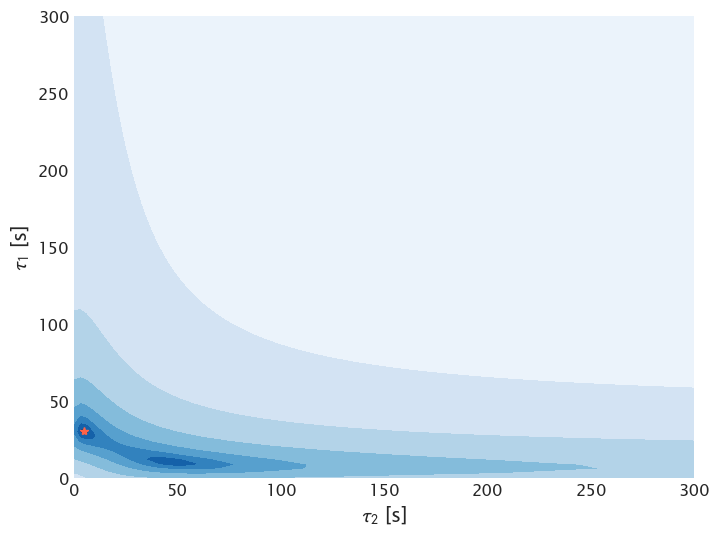

In [371]:
# Rescale the posterior
tau_posterior = tau_posterior / tau_posterior.sum()

# Set up the figure. 
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(r'$\tau_2$ [s]')
ax.set_ylabel(r'$\tau_1$ [s]')

# Plot the contours
ax.contourf(tau_x, tau_y, np.exp(tau_posterior), cmap='Blues_r')

# Plot the most likely values.
ax.plot(tau_2, tau_1, '*', color='tomato')

Notice that this posterior *is not unimodal*, this is because there is some degeneracy in the parameters meaning that $\tau_1$ or $\tau_2$ can be swapped, so long as the $I_0^{(1)}$ and $I_0^{(2)}$ are also swapped. There are some ways in which this can be corrected, but we will not go into them here. 

We can now compute the biexponential fit and plot it against our data and the fit from a single exponential model.

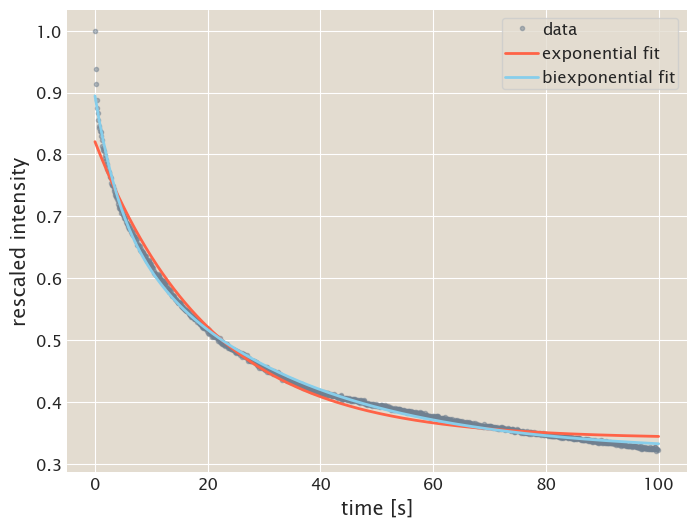

In [372]:
# Compute the biexponential fit.
biexp_fit = beta_biexp + I_0_1 * np.exp(-time_range / tau_1) + I_0_2 * np.exp(-time_range / tau_2)

# Set up the figure
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('rescaled intensity')

# Plot the data dn the two fits. 
_ = ax.plot(time_vals, average_rescaled, '.', color='slategray', alpha=0.5, label='data')
_ = ax.plot(time_range, exp_fit, '-', color='tomato', label='exponential fit')
_ = ax.plot(time_range, biexp_fit, '-', color='skyblue', label='biexponential fit')
_ = ax.legend()

By eye, the biexponential fit does a much better job at describing the data, however it is still not perfect. This means there are likely more than two species of fluorophore in the mix, making a higher order exponential decay perhaps more appropriate. However, one can always improve the fit by adding more parameters. As the biexponential model does a very good job at describing the entire trajectory, we will use the constants fit from this model to correct from photobleaching.